In [1]:
import os
import json
import joblib

import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

import preprocessing as prep
import machine_learning as ml
from pipeline import AnomalyDetectionPipeline, load_model, evaluate_model

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

In [2]:
DATASETS = {
    'TOTF': {
        'path': 'data/TOTF.PA-book/2015-01-02-TOTF.PA-book.csv.gz',
        'type': 'standard_csv'
    },

    'LOBSTER': {
        'orderbook': 'data/LOBSTER/AMZN_2012-06-21_34200000_57600000_orderbook_10.csv',
        'message': 'data/LOBSTER/AMZN_2012-06-21_34200000_57600000_message_10.csv',
        'type': 'lobster'
    }
}

ALL_RESULTS = []
ROC_DATA = {}

In [3]:
for dataset_name, data_config in DATASETS.items():
    print(f"Processing dataset: {dataset_name}")
    
    pipeline_setup = AnomalyDetectionPipeline()
    if data_config['type'] == 'lobster':
        df = prep.load_lobster_data(
            orderbook_path=data_config['orderbook'], 
            message_path=data_config['message'], 
            levels=10
        )
        pipeline_setup.raw_df = df
    else:
        pipeline_setup.load_data(data_config['path'])
    
    pipeline_setup.engineer_features(feature_sets=['base', 'tao', 'hawkes', 'poutre', 'ofi'])
    # Extract test data
    test_start_idx = int(len(pipeline_setup.processed_df) * 0.85)
    test_df = pipeline_setup.processed_df.iloc[test_start_idx:].reset_index(drop=True)
    print(f"Test data shape: {test_df.shape}")

    # Load saved models
    saved_files = [f for f in os.listdir('models') if f.endswith('_config.json') and dataset_name in f]

    for config_file in saved_files:
        print(f"Evaluating model from config: {config_file}")
        try:
            # Load model
            loaded_pipeline, config = load_model(
                f"models/{config_file}",
                test_df,
                pipeline_setup.feature_names
            )

            # Evaluate model
            results, y_true, y_scores, cm = evaluate_model(loaded_pipeline, config)

            tn, fp, fn, tp = cm.ravel()
            total = np.sum(cm)

            record = {
                'dataset': dataset_name,
                'model': config['model_type'],
                'scaler': config['scaler_type'],
                'auroc': results['AUROC'],
                'auprc': results['AUPRC'],
                'f4_score': results['F4_Score'],
                'TN': tn / total,
                'FP': fp / total,
                'FN': fn / total,
                'TP': tp / total
            }

            ALL_RESULTS.append(record)

            key = f"{config['model_type']} + {config['scaler_type']}"
            ROC_DATA[key] = (y_true, y_scores)
        
        except Exception as e:
            print(f"Error evaluating model {config_file}: {e}")


Processing dataset: TOTF
Pipeline initialized on device: cuda
Loading data from data/TOTF.PA-book/2015-01-02-TOTF.PA-book.csv.gz...
Successfully loaded 640429 rows.
Engineering features: ['base', 'tao', 'hawkes', 'poutre', 'ofi']...
Feature Engineering complete. Total features: 130
Test data shape: (96065, 130)
Evaluating model from config: TOTF_box-cox_pnn_config.json
Pipeline initialized on device: cuda
Evaluating model...
Evaluating model from config: TOTF_box-cox_prae_config.json
Pipeline initialized on device: cuda
Evaluating model...
Evaluating model from config: TOTF_box-cox_transformer_ocsvm_config.json
Pipeline initialized on device: cuda
Evaluating model...
Evaluating model from config: TOTF_minmax_pnn_config.json
Pipeline initialized on device: cuda
Evaluating model...
Evaluating model from config: TOTF_minmax_prae_config.json
Pipeline initialized on device: cuda
Evaluating model...
Evaluating model from config: TOTF_minmax_transformer_ocsvm_config.json
Pipeline initialized 

In [4]:
# Results
results_df = pd.DataFrame(ALL_RESULTS)[['dataset', 'model', 'scaler', 'auroc', 'auprc', 'f4_score']]
results_df.sort_values(by='f4_score', ascending=False, inplace=True)
display(results_df)

,dataset,model,scaler,auroc,auprc,f4_score
4,TOTF,prae,minmax,1.000000,1.000000,0.999341
1,TOTF,prae,box-cox,0.999949,0.999948,0.999261
7,LOBSTER,prae,box-cox,1.000000,1.000000,0.998931
10,LOBSTER,prae,minmax,1.000000,1.000000,0.998801
8,LOBSTER,transformer_ocsvm,box-cox,1.000000,1.000000,0.998659
2,TOTF,transformer_ocsvm,box-cox,1.000000,1.000000,0.998647
9,LOBSTER,pnn,minmax,0.990356,0.981076,0.997798
3,TOTF,pnn,minmax,0.987284,0.975206,0.997494
5,TOTF,transformer_ocsvm,minmax,1.000000,1.000000,0.996756
11,LOBSTER,transformer_ocsvm,minmax,1.000000,1.000000,0.996091


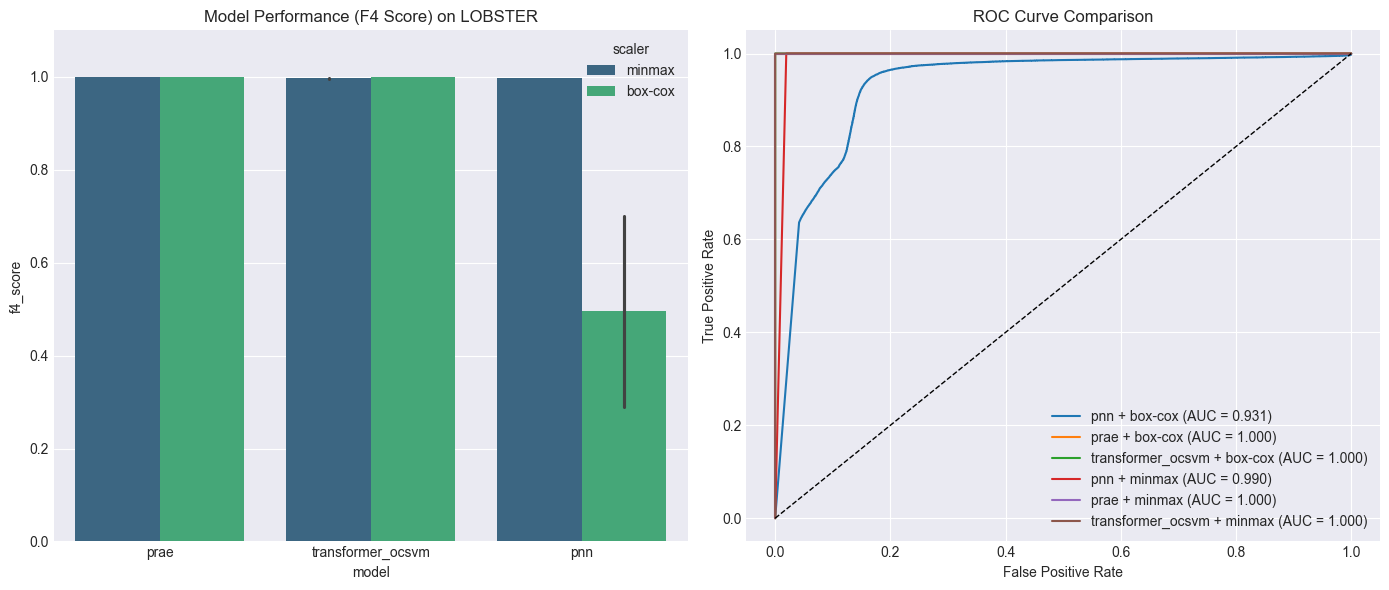

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(data=results_df, x='model', y='f4_score', hue='scaler', ax=ax[0], palette='viridis')
ax[0].set_title(f'Model Performance (F4 Score) on {dataset_name}')
ax[0].set_ylim(0, 1.1)

for label, (y_test, y_score) in ROC_DATA.items():
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    ax[1].plot(fpr, tpr, label=f'{label} (AUC = {roc_auc:.3f})')
ax[1].plot([0,1], [0,1], 'k--', lw=1)
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curve Comparison')
ax[1].legend(loc='lower right')

plt.tight_layout()
plt.grid(True)
plt.show()

In [7]:
# Confusion matrices
cm_df = pd.DataFrame(ALL_RESULTS)
cm_style = cm_df.sort_values(by=['dataset', 'f4_score'], ascending=[True, False]).style.background_gradient(
    subset=['TN', 'TP'], cmap='Greens'
).background_gradient(
    subset=['FP', 'FN'], cmap='Reds'
).format("{:.2%}", subset=['TN', 'FP', 'FN', 'TP'])

display(cm_style)

,dataset,model,scaler,auroc,auprc,f4_score,TN,FP,FN,TP
7,LOBSTER,prae,box-cox,1.000000,1.000000,0.998931,49.09%,0.91%,0.00%,50.00%
10,LOBSTER,prae,minmax,1.000000,1.000000,0.998801,48.98%,1.02%,0.00%,50.00%
8,LOBSTER,transformer_ocsvm,box-cox,1.000000,1.000000,0.998659,48.86%,1.14%,0.00%,50.00%
9,LOBSTER,pnn,minmax,0.990356,0.981076,0.997798,48.12%,1.88%,0.00%,50.00%
11,LOBSTER,transformer_ocsvm,minmax,1.000000,1.000000,0.996091,46.66%,3.34%,0.00%,50.00%
6,LOBSTER,pnn,box-cox,0.931377,0.910007,0.700142,46.62%,3.38%,15.49%,34.51%
4,TOTF,prae,minmax,1.000000,1.000000,0.999341,49.44%,0.56%,0.00%,50.00%
1,TOTF,prae,box-cox,0.999949,0.999948,0.999261,49.37%,0.63%,0.00%,50.00%
2,TOTF,transformer_ocsvm,box-cox,1.000000,1.000000,0.998647,48.85%,1.15%,0.00%,50.00%
3,TOTF,pnn,minmax,0.987284,0.975206,0.997494,47.91%,2.09%,0.00%,50.00%


In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from pipeline import AnomalyDetectionPipeline, load_model, LazySequenceDataset

# New data
DATA_PATH = 'data/TOTF.PA-book/2015-01-05-TOTF.PA-book.csv.gz'

# Pipeline for feature engineering
prep_pipeline = AnomalyDetectionPipeline()
prep_pipeline.load_data(DATA_PATH, nrows=50_000)

# Engineer features
prep_pipeline.engineer_features(feature_sets=['base', 'tao', 'hawkes', 'poutre', 'ofi'])

full_features_df = prep_pipeline.processed_df

Pipeline initialized on device: cuda
Loading data from data/TOTF.PA-book/2015-01-05-TOTF.PA-book.csv.gz...
Successfully loaded 50000 rows.
Engineering features: ['base', 'tao', 'hawkes', 'poutre', 'ofi']...
Feature Engineering complete. Total features: 130


Running inference with model config: TOTF_box-cox_pnn_config.json
Pipeline initialized on device: cuda


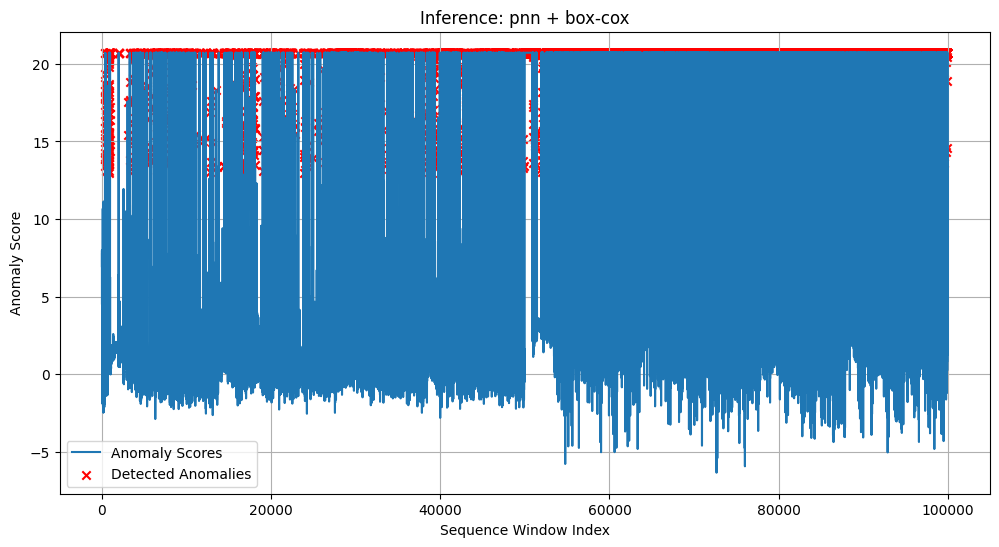

Running inference with model config: TOTF_box-cox_prae_config.json
Pipeline initialized on device: cuda


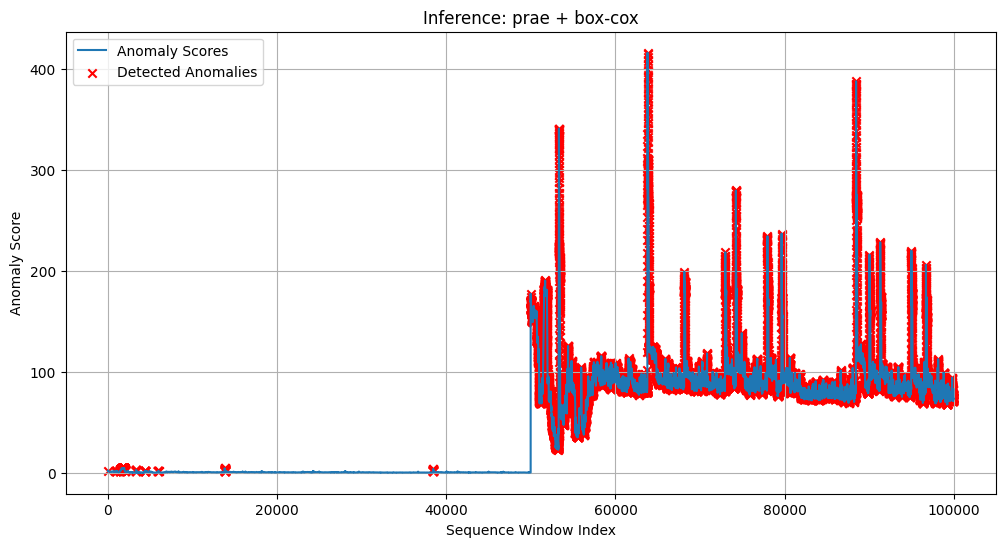

Running inference with model config: TOTF_box-cox_transformer_ocsvm_config.json
Pipeline initialized on device: cuda


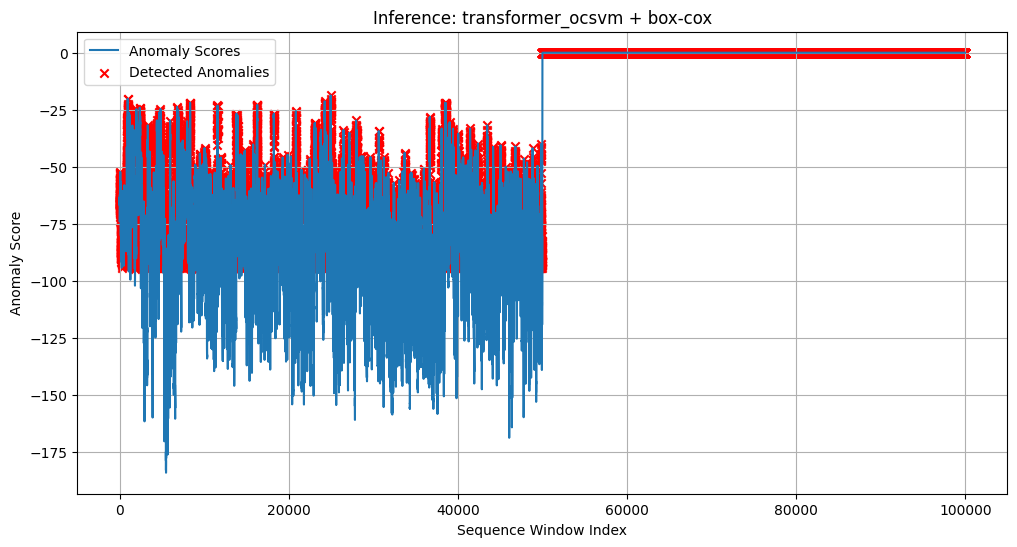

Running inference with model config: TOTF_minmax_pnn_config.json
Pipeline initialized on device: cuda


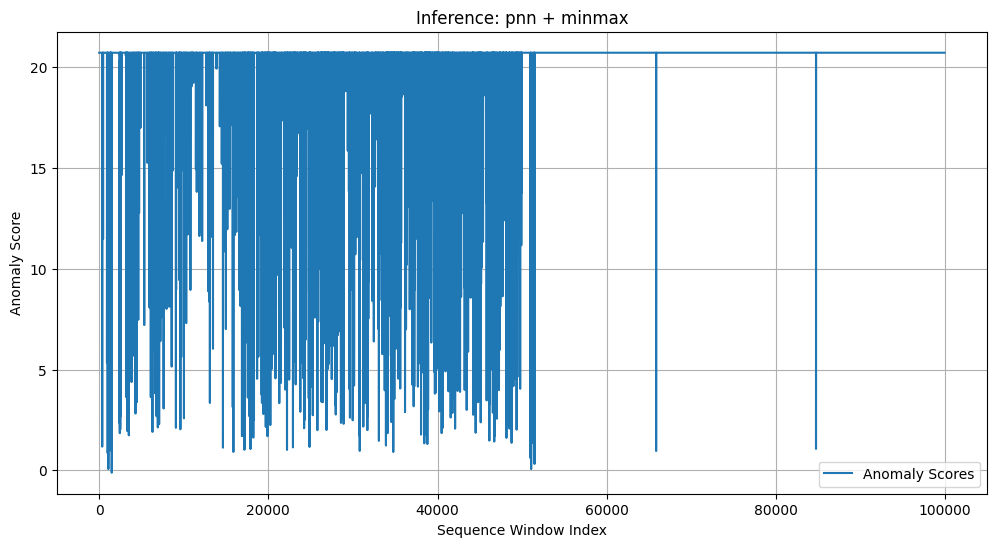

Running inference with model config: TOTF_minmax_prae_config.json
Pipeline initialized on device: cuda


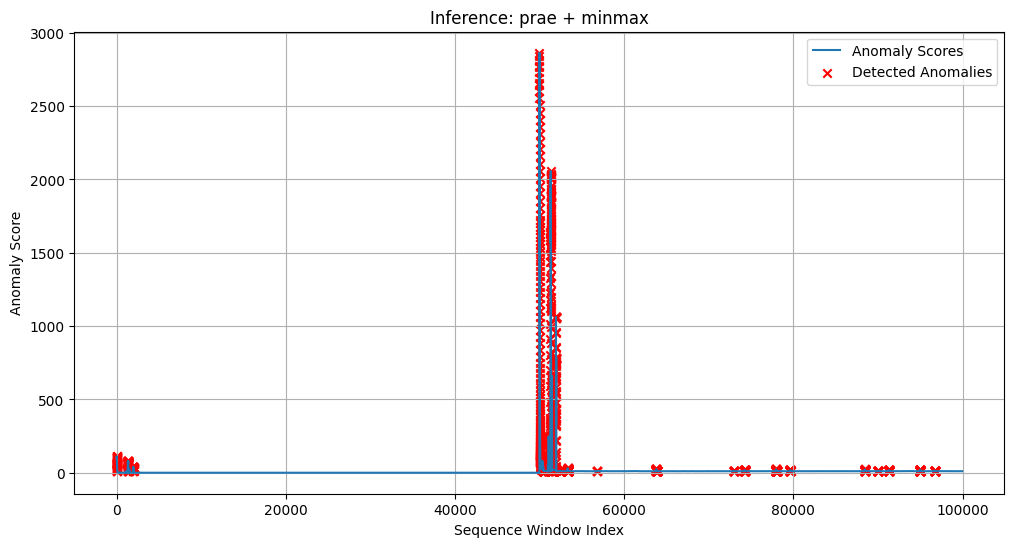

Running inference with model config: TOTF_minmax_transformer_ocsvm_config.json
Pipeline initialized on device: cuda


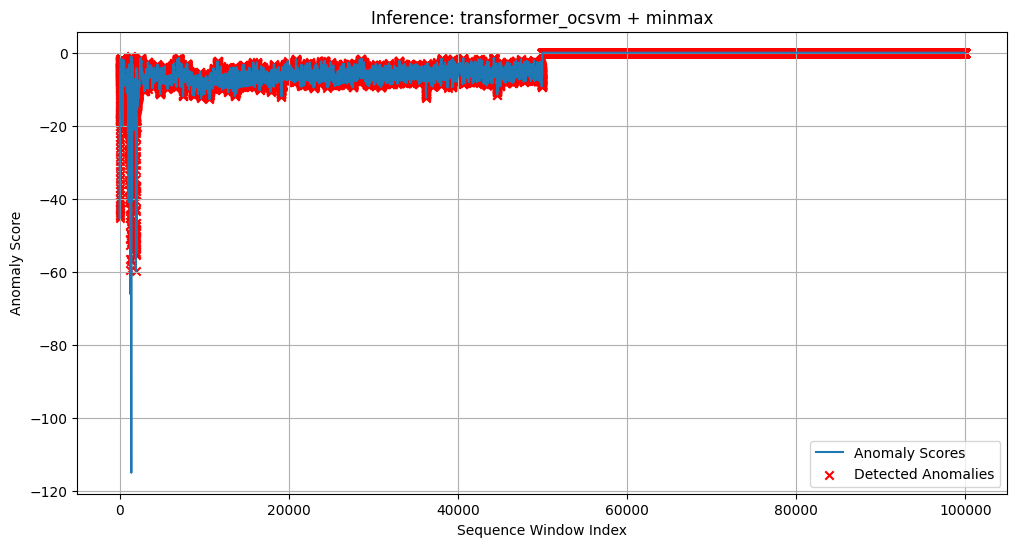

,model,scaler,samples,anomalies,anomaly_percentage,average_score
0,pnn,box-cox,99950,40315,40.335168,9.158916
1,prae,box-cox,99950,50613,50.638319,46.836113
2,transformer_ocsvm,box-cox,99950,82625,82.666333,-43.300407
3,pnn,minmax,99950,0,0.000000,20.544788
4,prae,minmax,99950,2411,2.412206,9.065184
5,transformer_ocsvm,minmax,99950,99936,99.985993,-3.198729


In [2]:
model_configs = [f for f in os.listdir('models') if 'TOTF' in f and f.endswith('_config.json')]
inference_results = []

for config_file in model_configs:
    print(f"Running inference with model config: {config_file}")
    dummy_df = full_features_df.head(100)
    loaded_pipeline, config = load_model(
        f"models/{config_file}",
        dummy_df,
        prep_pipeline.feature_names
    )

    try:
        X_values = full_features_df[config['feature_names']].values
    except KeyError as e:
        common_features = [f for f in config['feature_names'] if f in full_features_df.columns]
        X_values = full_features_df[common_features].values
        print(f"Warning: Some features from the model config are missing in the data. Using common features only.")

    X_scaled_full = loaded_pipeline.scaler.transform(X_values)

    sequence_length = config['seq_length']
    lazy_dataset = LazySequenceDataset(X_scaled_full, sequence_length)
    loaded_pipeline.X_test = lazy_dataset

    if config['model_type'] == 'pnn':
        dummy_targets = np.zeros(len(lazy_dataset))
        loaded_pipeline.y_test = LazySequenceDataset(
            X_scaled_full, 
            sequence_length, 
            targets=np.zeros(len(X_scaled_full))
        )

    model_type = config['model_type']
    scaler_type = config['scaler_type']

    # Run inference
    if model_type == 'transformer_ocsvm':
        _, scores, preds = loaded_pipeline.evaluate_transformer_ocsvm(y_true=None)
        threshold_type = "Learned Decision Boundary"
        
    elif model_type == 'prae':
        _, scores, preds = loaded_pipeline.evaluate_prae(y_true=None)
        threshold_type = "Dynamic (Mean + 3*Std)"
        
    elif model_type == 'pnn':
        _, scores, preds = loaded_pipeline.evaluate_pnn(y_true=None)
        threshold_type = "Dynamic (Mean + 2*Std)"

    anomaly_count = preds.sum()
    total_samples = len(preds)
    anomaly_percentage = anomaly_count / total_samples * 100

    inference_results.append({
        'model': model_type,
        'scaler': scaler_type,
        'samples': total_samples,
        'anomalies': anomaly_count,
        'anomaly_percentage': anomaly_percentage,
        'average_score': scores.mean()
    })

    plt.figure(figsize=(12, 6))
    plt.plot(scores, label='Anomaly Scores')

    anom_indices = [i for i, p in enumerate(preds) if p == 1]
    if anom_indices:
        plt.scatter(anom_indices, scores[anom_indices], color='red', label='Detected Anomalies', marker='x')
    
    plt.title(f"Inference: {model_type} + {scaler_type}")
    plt.xlabel("Sequence Window Index")
    plt.ylabel("Anomaly Score")
    plt.legend()
    plt.grid(True)
    plt.show()

# Summary of inference results
results_df = pd.DataFrame(inference_results)
display(results_df)